In [2]:
import os
from argparse import ArgumentParser

import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import mmcv
import numpy as np
from nuscenes.utils.data_classes import Box, LidarPointCloud
from pyquaternion import Quaternion

from bevdepth.datasets.nusc_det_dataset import map_name_from_general_to_detection

In [13]:
def get_ego_box(box_dict, ego2global_rotation, ego2global_translation):
    box = Box(
        box_dict['translation'],
        box_dict['size'],
        Quaternion(box_dict['rotation']),
    )
    trans = -np.array(ego2global_translation)
    rot = Quaternion(ego2global_rotation).inverse
    box.translate(trans)
    box.rotate(rot)
    box_xyz = np.array(box.center)
    box_dxdydz = np.array(box.wlh)[[1, 0, 2]]
    box_yaw = np.array([box.orientation.yaw_pitch_roll[0]])
    box_velo = np.array(box.velocity[:2])
    return np.concatenate([box_xyz, box_dxdydz, box_yaw, box_velo])


def rotate_points_along_z(points, angle):
    """
    Args:
        points: (B, N, 3 + C)
        angle: (B), angle along z-axis, angle increases x ==> y
    Returns:
    """
    cosa = np.cos(angle)
    sina = np.sin(angle)
    zeros = np.zeros(points.shape[0])
    ones = np.ones(points.shape[0])
    rot_matrix = np.stack(
        (cosa, sina, zeros, -sina, cosa, zeros, zeros, zeros, ones),
        axis=1).reshape(-1, 3, 3)
    points_rot = np.matmul(points[:, :, 0:3], rot_matrix)
    points_rot = np.concatenate((points_rot, points[:, :, 3:]), axis=-1)
    return points_rot


def get_corners(boxes3d):
    """
        7 -------- 4
       /|         /|
      6 -------- 5 .
      | |        | |
      . 3 -------- 0
      |/         |/
      2 -------- 1
    Args:
        boxes3d:  (N, 7) [x, y, z, dx, dy, dz, heading],
            (x, y, z) is the box center
    Returns:
    """
    template = (np.array((
        [1, 1, -1],
        [1, -1, -1],
        [-1, -1, -1],
        [-1, 1, -1],
        [1, 1, 1],
        [1, -1, 1],
        [-1, -1, 1],
        [-1, 1, 1],
    )) / 2)

    corners3d = np.tile(boxes3d[:, None, 3:6], [1, 8, 1]) * template[None, :, :]
    corners3d = rotate_points_along_z(corners3d.reshape(-1, 8, 3),boxes3d[:, 6]).reshape(-1, 8, 3)
    corners3d += boxes3d[:, None, 0:3]

    return corners3d

def get_bev_lines(corners):
    return [[[corners[i, 0], corners[(i + 1) % 4, 0]],
             [corners[i, 1], corners[(i + 1) % 4, 1]]] for i in range(4)]

def get_3d_lines(corners):
    ret = []
    for st, ed in [[0, 1], [1, 2], [2, 3], [3, 0], [4, 5], [5, 6], [6, 7],
                   [7, 4], [0, 4], [1, 5], [2, 6], [3, 7]]:
        if corners[st, -1] > 0 and corners[ed, -1] > 0:
            ret.append([[corners[st, 0], corners[ed, 0]],
                        [corners[st, 1], corners[ed, 1]]])
    return ret

def get_cam_corners(corners, translation, rotation, cam_intrinsics):
    cam_corners = corners.copy()
    cam_corners -= np.array(translation)
    cam_corners = cam_corners @ Quaternion(rotation).inverse.rotation_matrix.T
    cam_corners = cam_corners @ np.array(cam_intrinsics).T
    valid = cam_corners[:, -1] > 0
    cam_corners /= cam_corners[:, 2:3]
    cam_corners[~valid] = 0
    return cam_corners

def demo(
    idx,
    nusc_results_file,
    dump_file,
    infos_path,
    data_root,
    threshold=0.0,
    show_range=60,
    show_classes=[
        'car',
        'truck',
        'construction_vehicle',
        'bus',
        'trailer',
        'barrier',
        'motorcycle',
        'bicycle',
        'pedestrian',
        'traffic_cone',
    ],
):
    # Set cameras
    IMG_KEYS = [
        'CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_RIGHT',
        'CAM_BACK', 'CAM_BACK_LEFT'
    ]
    infos = mmcv.load(infos_path)
    assert idx < len(infos)
    
    # Get data from dataset
    results = mmcv.load(nusc_results_file)['results']
    info = infos[idx]
    lidar_path = info['lidar_infos']['LIDAR_TOP']['filename']
    lidar_points = np.fromfile(os.path.join(data_root, lidar_path), dtype=np.float32, count=-1).reshape(-1, 5)[..., :4]
    lidar_calibrated_sensor = info['lidar_infos']['LIDAR_TOP'][
        'calibrated_sensor']
    
    # Get point cloud
    pts = lidar_points.copy()
    ego2global_rotation = np.mean([info['cam_infos'][cam]['ego_pose']['rotation'] for cam in IMG_KEYS], 0)
    ego2global_translation = np.mean([info['cam_infos'][cam]['ego_pose']['translation'] for cam in IMG_KEYS], 0)
    lidar_points = LidarPointCloud(lidar_points.T)
    lidar_points.rotate(Quaternion(lidar_calibrated_sensor['rotation']).rotation_matrix)
    lidar_points.translate(np.array(lidar_calibrated_sensor['translation']))
    pts = lidar_points.points.T

    # Get GT corners
    gt_corners = []
    for i in range(len(info['ann_infos'])):
        if map_name_from_general_to_detection[info['ann_infos'][i]['category_name']] in show_classes:
            box = get_ego_box(
                dict(
                    size=info['ann_infos'][i]['size'],
                    rotation=info['ann_infos'][i]['rotation'],
                    translation=info['ann_infos'][i]['translation'],
                ), ego2global_rotation, ego2global_translation)
            if np.linalg.norm(box[:2]) <= show_range:
                corners = get_corners(box[None])[0]
                gt_corners.append(corners)

    # Get prediction corners
    pred_corners, pred_class = [], []
    for box in results[info['sample_token']]:
        if box['detection_score'] >= threshold and box['detection_name'] in show_classes:
            box3d = get_ego_box(box, ego2global_rotation, ego2global_translation)
            box3d[2] += 0.5 * box3d[5]  # NOTE
            if np.linalg.norm(box3d[:2]) <= show_range:
                corners = get_corners(box3d[None])[0]
                pred_corners.append(corners)
                pred_class.append(box['detection_name'])

    # Set figure size
    plt.figure(figsize=(24, 8))

    for i, k in enumerate(IMG_KEYS):
        # Draw camera views
        fig_idx = i + 1 if i < 3 else i + 2
        plt.subplot(2, 4, fig_idx)

        # Set camera attributes
        plt.title(k)
        plt.axis('off')
        plt.xlim(0, 1600)
        plt.ylim(900, 0)

        img = mmcv.imread(os.path.join(data_root, info['cam_infos'][k]['filename']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw images
        plt.imshow(img)

        # Draw 3D predictions
        for corners, cls in zip(pred_corners, pred_class):
            cam_corners = get_cam_corners(
                corners,
                info['cam_infos'][k]['calibrated_sensor']['translation'],
                info['cam_infos'][k]['calibrated_sensor']['rotation'],
                info['cam_infos'][k]['calibrated_sensor']['camera_intrinsic'])
            lines = get_3d_lines(cam_corners)
            for line in lines:
                plt.plot(line[0],
                         line[1],
                         c=cm.get_cmap('tab10')(show_classes.index(cls)))

    # Draw BEV
    plt.subplot(1, 4, 4)

    # Set BEV attributes
    plt.title('LIDAR_TOP')
    plt.axis('equal')
    plt.xlim(-40, 40)
    plt.ylim(-40, 40)

    # Draw point cloud
    plt.scatter(-pts[:, 1], pts[:, 0], s=0.01, c=pts[:, -1], cmap='gray')

    # Draw BEV GT boxes
    for corners in gt_corners:
        lines = get_bev_lines(corners)
        for line in lines:
            plt.plot([-x for x in line[1]],
                     line[0],
                     c='r',
                     label='ground truth')

    # Draw BEV predictions
    for corners in pred_corners:
        lines = get_bev_lines(corners)
        for line in lines:
            plt.plot([-x for x in line[1]], line[0], c='g', label='prediction')

    # Set legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(),
               by_label.keys(),
               loc='upper right',
               framealpha=1)

    # Save figure
    plt.tight_layout(w_pad=0, h_pad=2)
    # plt.savefig(dump_file)

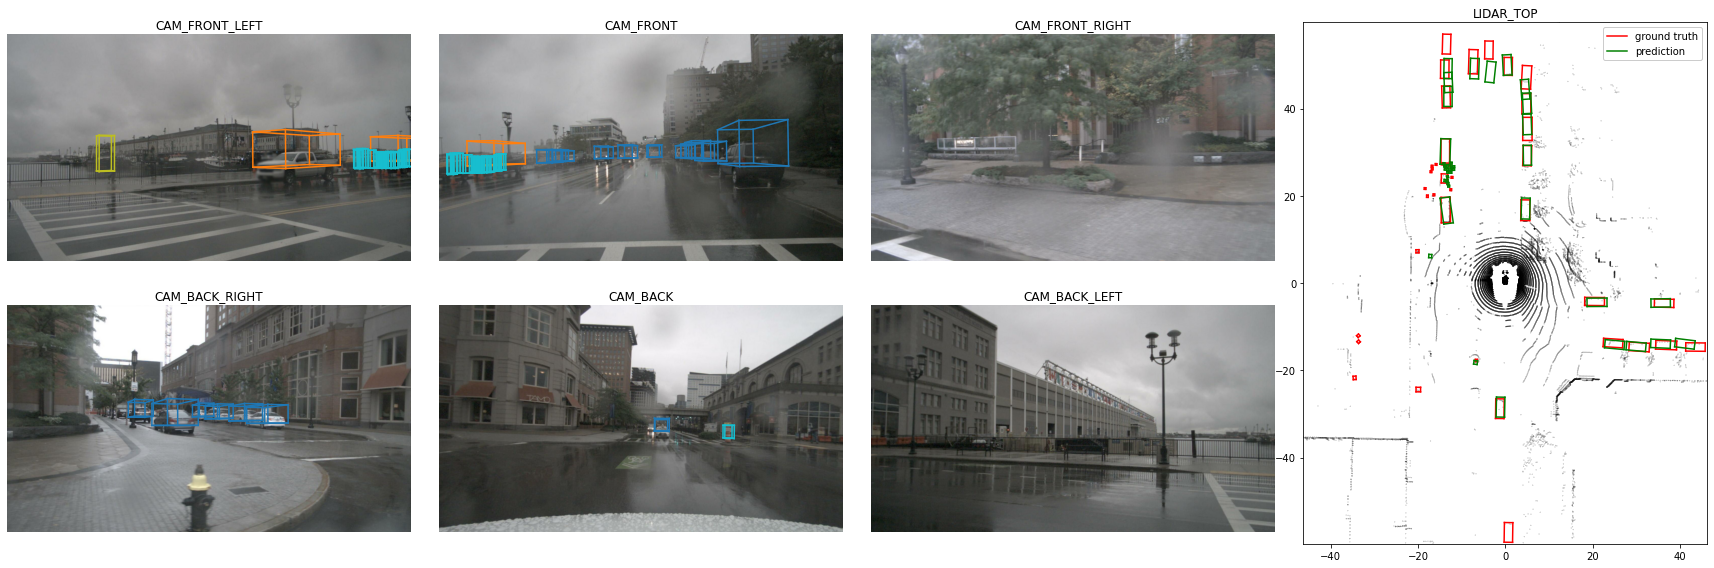

In [22]:
result_path = './outputs/bevstereo_ema_da_key2/lightning_logs/version_0/results_nusc.json'
target_path = './outputs/bevstereo_ema_da_key2/lightning_logs/version_0/'
infos_path = '../data/nuscenes/nuscenes_infos_val.pkl'
data_root = '../data/nuscenes/'

# Change here!
nus_idx = 4100
threshold = 0.3

demo(idx=nus_idx,
     nusc_results_file=result_path,
     dump_file=target_path,
     infos_path=infos_path,
     data_root=data_root,
     threshold=threshold)